In [117]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from tqdm import tqdm
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

### Chargement des données

In [118]:
Data = pd.read_csv('D:\Projet\Y_train_ofTdMHi.csv',header=0)
y = Data['pos_label'].to_numpy()
X = np.load('data.npy')
X = np.delete(X, (0), axis=0)
y = y.reshape((y.shape[0],1))

### Fabrication des données d'entrainement et de test

In [119]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

X_train = X_train.T
X_test = X_test.T

y_train = y_train.reshape((1, y_train.shape[0]))

In [120]:
y_train.shape
X_train.shape

(17, 15522)

In [121]:
def initialisation(n0, n1, n2):
    W1 = np.random.randn(n1, n0)
    b1 = np.random.randn(n1, 1)
    W2 = np.random.randn(n2, n1)
    b2 = np.random.randn(n2, 1)

    parametres = {
        'W1' : W1,
        'b1' : b1,
        'W2' : W2,
        'b2' : b2
    }


    return parametres 

In [122]:
def forward_propagation(X, parametres):
    W1 = parametres['W1']
    b1 = parametres['b1']
    W2 = parametres['W2']
    b2 = parametres['b2']


    Z1 = W1.dot(X) + b1
    A1 = 1/(1 + np.exp(-Z1))

    Z2 = W2.dot(A1) + b2
    A2 = 1/(1 + np.exp(-Z2))

    activations = {
        'A1' : A1,
        'A2' : A2

    }

    return activations

In [123]:
def back_propagation(X, y, activations, parametres):
    A1 = activations['A1']
    A2 = activations['A2']
    W2 = parametres['W2']

    m = y.shape[1]
    dZ2 = A2 - y
    dW2 = 1 / m * dZ2.dot(A1.T)
    db2 = 1 / m * np.sum(dZ2, axis=1, keepdims=True)

    dZ1 = np.dot(W2.T, dZ2) * A1 * (1-A1)
    dW1 = 1 / m * dZ1.dot(X.T)
    db1 = 1 / m * np.sum(dZ1, axis=1, keepdims=True)

    gradients = {
        'dW1' : dW1,
        'db1' : db1,
        'dW2' : dW2,
        'db2' : db2
    }

    return gradients

In [124]:
def update(gradients, parametres, learning_rate):
    W1 = parametres['W1']
    b1 = parametres['b1']
    W2 = parametres['W2']
    b2 = parametres['b2']

    dW1 = gradients['dW1']
    db1 = gradients['db1']
    dW2 = gradients['dW2']
    db2 = gradients['db2']
    
    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1
    W2 = W2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2


    parametres = {
        'W1' : W1,
        'b1' : b1,
        'W2' : W2,
        'b2' : b2
    }
    
    return parametres

In [125]:
def predict(X, parametres):
    activations = forward_propagation(X, parametres)
    A2 = activations['A2']
    return A2 >= 0.5

In [126]:
def log_loss(A, y):
    epsilon = 1e-15
    return 1/len(y) * np.sum(-y * np.log(A + epsilon) - (1 - y) * np.log(1 - A + epsilon))

In [127]:
def neuron_network(X_train, y_train, n1, learning_rate = 0.1, n_iter = 1000):
    #Initialisation W, b
    n0 = X_train.shape[0]  # nombre d'entrée du réseau
    n2 = y_train.shape[0] #nombre de neuronne dans la couche 2

    parametres = initialisation(n0, n1, n2)

    train_loss = []
    train_acc = []

    
    # Boucle d'apprentissage
    for i in tqdm(range(n_iter)):
        ##### Train #####
        # Activation

        activations = forward_propagation(X_train, parametres)
        gradients = back_propagation( X_train, y_train, activations, parametres)
        parametres = update(gradients, parametres, learning_rate)

        if n_iter % 10 == 0 :
        # Visualisation
            train_loss.append(log_loss(y_train,activations['A2']))
            y_pred = predict(X_train, parametres)
            current_acc = accuracy_score(y_train.flatten(), y_pred.flatten())
            train_acc.append(current_acc)

        
    
    plt.figure(figsize=(14,4))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label='train loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(train_acc, label='train acc')
    plt.legend()
    plt.show()
    return parametres 



In [128]:
def normalisation_Min_Max(X):
    # Boucler sur les colonnes et soustraire le min et le max de chaque colonne
    for i in range(X.shape[1]):  # arr.shape[1] donne le nombre de colonnes
        col = X[:, i]  # Extraire la i-ème colonne
        col_min = np.amin(col)  # Trouver le minimum de la colonne
        col_max = np.amax(col)  # Trouver le maximum de la colonne
        X[:, i] = col - col_min  # Soustraire le minimum de la colonne de chaque élément
        X[:, i] /= (col_max - col_min)  # Diviser par la différence entre le max et le min pour normaliser entre 0 et 1

    return X

## Calcul du model

In [129]:
X_train_norm_Min_Max = normalisation_Min_Max(X_train)
X_test_norm_Min_Max = normalisation_Min_Max(X_test)

X_train_norm = normalize(X_train, norm='l2')


100%|██████████| 20000/20000 [16:30<00:00, 20.20it/s] 


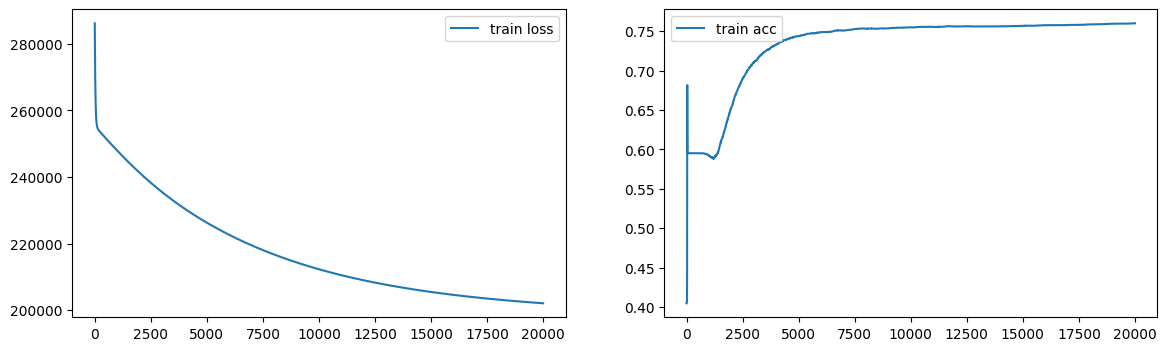

In [130]:
parametres = neuron_network(X_train_norm_Min_Max, y_train, n1=32, learning_rate=0.01, n_iter=20000)

## Cacule des prédictions sur les données TEST

### Chargement des features TEST

Ils sont calculés à partir du fichier Supervised_classification

In [146]:
X_test_fin = np.load('data_Test.npy').T
X_test_norm_fin = normalisation_Min_Max(X_test_fin)
X_test_norm_fin = np.delete(X_test_norm_fin,0,1)

In [149]:
prediction = forward_propagation(X_test_norm_fin, parametres)

In [150]:
predict_fin = prediction['A2']

In [151]:
df_test_info = pd.read_csv(r'C:\Users\roman\Documents\projet_Biosonar\Y_test.csv',header=0)

In [152]:
df_test_info

,id
0,23168-TEST.wav
1,23169-TEST.wav
2,23170-TEST.wav
3,23171-TEST.wav
4,23172-TEST.wav
...,...
945,24113-TEST.wav
946,24114-TEST.wav
947,24115-TEST.wav
948,24116-TEST.wav


In [153]:
FIN = np.concatenate((df_test_info,predict_fin.T),axis=1)

In [154]:
FIN

array([['23168-TEST.wav', 0.28118782652538693],
       ['23169-TEST.wav', 0.5782460632803605],
       ['23170-TEST.wav', 0.3496370561951541],
       ...,
       ['24115-TEST.wav', 0.4645866866960962],
       ['24116-TEST.wav', 0.7547336121519197],
       ['24117-TEST.wav', 0.28244296569609423]], dtype=object)

In [163]:
np.savetxt('Y_test_Roman.csv', FIN, delimiter=',',header="ID,pos_label",fmt='%s')